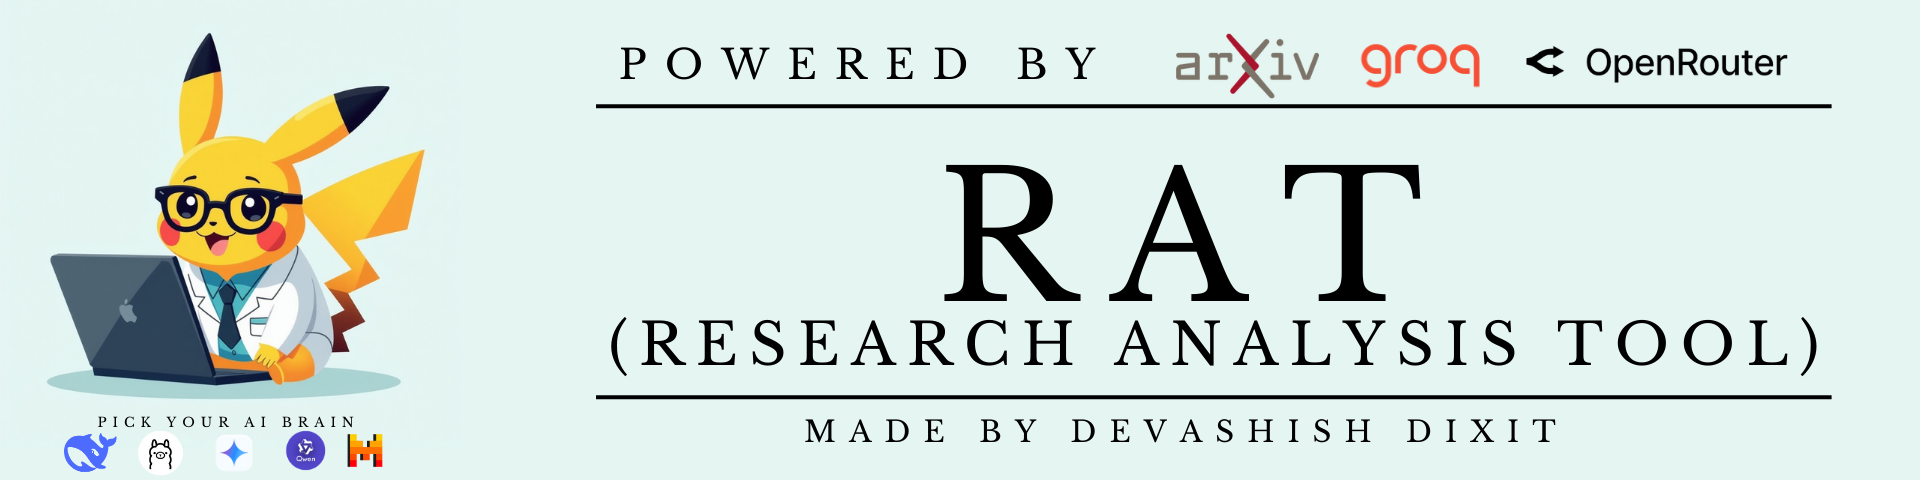

# RAT (Research Analysis Tool)
**Meet RAT – Your AI Research Buddy!**  🐹⚡📚  

Diving into research papers can feel like searching for a needle in a haystack—but that’s where RAT (Research Analysis Tool) comes in! RAT makes exploring academic research easy by fetching papers from arXiv based on your queries and organizing the key details (titles, authors, abstracts, and PDF links)all in one place. But that’s just the start! You can generate AI-powered summaries for all the papers using your favorite model (DeepSeek, Google Gemini 2.0 Experimental, LLaMA, Mistral, or Qwen) and get a big-picture analysis of emerging trends, research gaps, and game-changing questions in your field. At any point of the analysis you can export the results as csvs which can be used for advance analysis on platforms like claude. Plus, RAT even helps with citations, so you can focus on what really matters.







## 📦 Setup & Imports


### 1. **Install `wkhtmltopdf`**

### Linux (Debian/Ubuntu)
```bash
sudo apt-get install -y wkhtmltopdf
```

### macOS (using Homebrew)
```bash
brew install wkhtmltopdf
```

### Windows
1. Download the installer from [wkhtmltopdf Downloads](https://wkhtmltopdf.org/downloads.html)
2. Install it and add its path to the system environment variables.

### 2. **Clone the Repository and Install Dependencies**

```bash
git clone https://github.com/Devashish-dixit/RAT
cd RAT
pip install -r requirements.txt
```

This will install the required dependencies, including:
- `groq`
- `pandas`
- `nest_asyncio`
- `requests`
- `beautifulsoup4`
- `markdown`
- `pdfkit`

### 3. **Verify Installation**
To check if `wkhtmltopdf` is installed correctly, run:
```bash
wkhtmltopdf --version
```

Now you're all set to run the notebook locally! 🚀

In [ ]:
import asyncio
import time
import os
import csv
import json
import requests
import urllib.parse
from bs4 import BeautifulSoup
import pandas as pd
import re
import markdown
import pdfkit
import nest_asyncio
from groq import Groq
from openai import OpenAI

## 🔑 API Key Vault

In [ ]:
os.environ['GROQ_API_KEY'] = 'YOUR_GROQ_API_KEY'
os.environ['OPENROUTER_API_KEY'] = 'YOUR_OPENROUTER_API_KEY'

## 🌐 Web Scraping Hub

In [ ]:
nest_asyncio.apply()

def clean_text(text):
    return re.sub(r'^(Authors:|Abstract:)\s*', '', re.sub(r'\s+', ' ', str(text)).strip()) if text else ''

def parse_arxiv_results(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    papers = []

    for container in soup.find_all('li', class_='arxiv-result'):
        try:
            papers.append({
                'title': clean_text(container.find('p', class_='title').text),
                'authors': clean_text(container.find('p', class_='authors').text),
                'abstract': clean_text(container.find('p', class_='abstract').text),
                'pdf_link': container.find('a', href=lambda href: href and '/pdf/' in href)['href']
            })
        except Exception as e:
            print(f"Parsing error: {e}")

    return papers

async def crawl_arxiv(base_url, max_pages):
    all_papers = []
    current_page = 0

    while current_page < max_pages:
        try:

            start = current_page * 50
            url = f"{base_url}&start={start}" if '?' in base_url else f"{base_url}?start={start}"

            print(f"Crawling page {current_page + 1}/{max_pages}")
            response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
            response.raise_for_status()

            papers = parse_arxiv_results(response.text)


            if not papers:
                print("No more results found.")
                break

            all_papers.extend(papers)
            current_page += 1

        except Exception as e:
            print(f"Crawling error on page {current_page + 1}: {e}")
            break

    return pd.DataFrame(all_papers)


def generate_arxiv_search_url(query):
    base_url = "https://arxiv.org/search/?query="
    encoded_query = urllib.parse.quote(query)
    search_url = f"{base_url}{encoded_query}&searchtype=all"
    return search_url

def run_arxiv_crawler():

    user_query = input("Enter your search query for arXiv: ")
    search_url = generate_arxiv_search_url(user_query)
    print(f"Generated Search URL: {search_url}")


    while True:
        try:
            max_pages = int(input("Enter the maximum number of pages to crawl: "))
            if max_pages > 0:
                break
            print("Please enter a positive number.")
        except ValueError:
            print("Please enter a valid number.")

    print(f"Starting crawler for {max_pages} pages...")
    return asyncio.run(crawl_arxiv(search_url, max_pages))

In [ ]:
df = run_arxiv_crawler()

In [ ]:
df.head()

### Download the Scraped data

In [ ]:
df.to_csv("arxiv_papers.csv", index=False)
from google.colab import files
files.download("arxiv_papers.csv")

## 📝 AI-Powered Summaries

In [ ]:
class GroqAbstractSummarizer:
    def __init__(self, model="deepseek-r1-distill-llama-70b"):
        self.client = Groq(api_key=os.environ.get("GROQ_API_KEY"))
        self.model = model

    def generate_summary(self, abstract):
        prompt = f"Summarize this research paper abstract in 1-2 sentences, focusing on the key findings and implications:\n\nAbstract: {abstract}\n\nProvide only the summary without any additional commentary."
        try:
            response = self.client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model=self.model,
                temperature=0.3,
            )
            if re.search(r'deepseek', self.model, re.IGNORECASE):
              return re.sub(r'<think>.*?</think>', '', response.choices[0].message.content, flags=re.DOTALL).strip()
            return response.choices[0].message.content
        except Exception as e:
            print(f"Error: {e}")
            return "Failed"

    def process_dataframe(self, df):
        df_out = df.copy()
        df_out['summary'] = None
        for idx, row in df_out.iterrows():
            if pd.notna(row['abstract']):
                df_out.at[idx, 'summary'] = self.generate_summary(row['abstract'])
        return df_out

In [ ]:
summarizer = GroqAbstractSummarizer(model="llama-3.1-8b-instant")
df_with_summaries = summarizer.process_dataframe(df)

In [ ]:
df_with_summaries.head()

### Download the Scraped data with AI generated summaries

In [ ]:
df_with_summaries.to_csv("arxiv_papers_with_summaries.csv", index=False)
from google.colab import files
files.download("arxiv_papers_with_summaries.csv")

### Download the Scraped data with AI generated summaries without the abstract column

In [ ]:
df_with_summaries.drop(columns=['abstract']).to_csv("arxiv_papers_with_summaries.csv", index=False)
from google.colab import files
files.download("arxiv_papers_with_summaries.csv")

## 🔍 Global Research Insights

In [ ]:
class OpenRouterResearchAnalyzer:
    def __init__(self, model="google/gemini-2.0-flash-lite-preview-02-05:free", api_key=None):
        """Initialize OpenRouter client"""
        api_key = api_key or os.environ.get('OPENROUTER_API_KEY')
        self.model=model
        if not api_key:
            raise ValueError("OpenRouter API key must be provided")

        self.client = OpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=api_key
        )

    def analyze_research_titles(self, df: pd.DataFrame) -> str:
        """Analyze research titles using Gemini"""
        research_data = []
        for _, row in df.iterrows():
                research_data.append({
                'title': row['title'],
                'summary': row['summary'] if pd.notna(row['summary']) else '',
                'pdf_link': row['pdf_link']
            })

        prompt = f"""Analyze these research papers in detail and generate output as a markdown:

Research Data:
{json.dumps(research_data, indent=2)}

Strictly provide:
1. Top 3 emerging research subfields and trends
2. 2-3 understudied research opportunities
3. Most promising breakthrough research questions
4. Potential cross-disciplinary insights
5.cite refernces using pdf links at the end of the output"""

        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[{"role": "user", "content": prompt}],
                extra_headers={
                    "HTTP-Referer": "https://github.com/Devashish-dixit",
                    "X-Title": "Research Analysis Tool"
                }
            )

            # Comprehensive error checking
            if not response:
                print("No response from API")
                return "Analysis failed: No API response"

            if not hasattr(response, 'choices') or not response.choices:
                print("No choices in API response")
                return "Analysis failed: No response choices"

            first_choice = response.choices[0]
            if not hasattr(first_choice, 'message') or not first_choice.message:
                print("No message in API response")
                return "Analysis failed: No response message"

            return first_choice.message.content or "No content generated"

        except Exception as e:
            print(f"Detailed Analysis error: {e}")
            return f"Analysis failed: {str(e)}"

In [ ]:
analyzer = OpenRouterResearchAnalyzer(model="deepseek/deepseek-r1-distill-llama-70b:free")
insights = analyzer.analyze_research_titles(df_with_summaries)
print(insights)

## 📄 Export & Download

In [ ]:
def extract_markdown(text):
    match = re.search(r"(# .*|## .*|### .*)", text, re.DOTALL)
    return match.group(1) if match else text

def markdown_to_pdf(md_text, output_filename="output.pdf"):
    html_text = markdown.markdown(md_text)

    options = {
        'page-size': 'A4',
        'encoding': 'UTF-8',
        'enable-local-file-access': None
    }

    pdfkit.from_string(html_text, output_filename, options=options)
    print(f"PDF saved as {output_filename}")

markdown_to_pdf(extract_markdown(insights), "insights.pdf")

from google.colab import files
files.download("insights.pdf")